<a href="https://colab.research.google.com/github/chinmaykatdare05/Emotion-Detection-on-TESS-using-LSTM/blob/main/Emotion_Detection_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Toronto Emotional Speech Set (TESS)***

[Dataset](https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess)

***About the Dataset:*** The TESS dataset is a high-quality, female-only audio dataset specifically designed for emotion classification tasks. It contains 2800 audio files, all in WAV format, organized by two female actresses (aged 26 and 64 years). The recordings capture seven distinct emotions:

1. Anger
2. Disgust
3. Fear
4. Happy
5. Surprise
6. Sad
7. Neutral

## ***Import Necessary Libraries***

In [1]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

## ***Load the Dataset***

In [2]:
dataset_dir = "/content/drive/MyDrive/Dataset"

file_paths = [(os.path.join(dataset_dir, emotion, file_name), emotion)
              for emotion in os.listdir(dataset_dir)
              if os.path.isdir(os.path.join(dataset_dir, emotion))
              for file_name in os.listdir(os.path.join(dataset_dir, emotion))]

# words = sorted(list({file_name.split("_")[1] for _, emotion in file_paths
#          for file_name in os.listdir(os.path.join(dataset_dir, emotion))}))

df = pd.DataFrame(file_paths, columns=['Path', 'Emotion'])
df.head()

,Path,Emotion
0,/content/drive/MyDrive/Dataset/Happy/OAF_cause...,Happy
1,/content/drive/MyDrive/Dataset/Happy/OAF_bough...,Happy
2,/content/drive/MyDrive/Dataset/Happy/OAF_back_...,Happy
3,/content/drive/MyDrive/Dataset/Happy/OAF_bar_h...,Happy
4,/content/drive/MyDrive/Dataset/Happy/OAF_bath_...,Happy


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Path     2800 non-null   object
 1   Emotion  2800 non-null   object
dtypes: object(2)
memory usage: 43.9+ KB


In [4]:
df['Emotion'].value_counts()

,count
Emotion,
Happy,400
Disgust,400
Sad,400
Fear,400
Angry,400
Neutral,400
Surprise,400


In [5]:
emotions = sorted((df['Emotion'].unique()))
emotions

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [6]:
# words[:5], len(words)

## ***Exploratory Data Analysis***

In [7]:
def create_waveplot(young_data, old_data, sr, e):
    plt.figure(figsize=(12, 3))

    # Plot YAF
    plt.subplot(1, 2, 1)
    plt.title(f'{e} (Young)', size=15)
    librosa.display.waveshow(young_data, sr=sr)

    # Plot OAF
    plt.subplot(1, 2, 2)
    plt.title(f'{e} (Old)', size=15)
    librosa.display.waveshow(old_data, sr=sr)

    plt.show()

def extract_mfcc(filename, duration=3, offset=0.5, n_mfcc=40):
    y, sr = librosa.load(filename, duration=duration, offset=offset)
    return np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc).T, axis=0)

### ***Plot the Waveform for each emotion with respect to Young and Old Lady's voice***

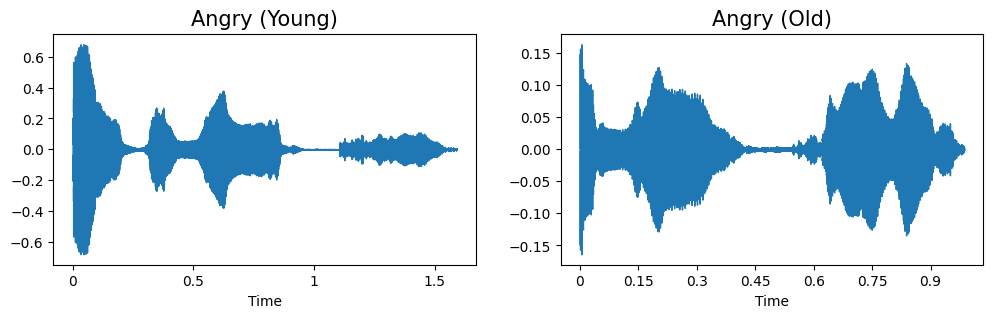

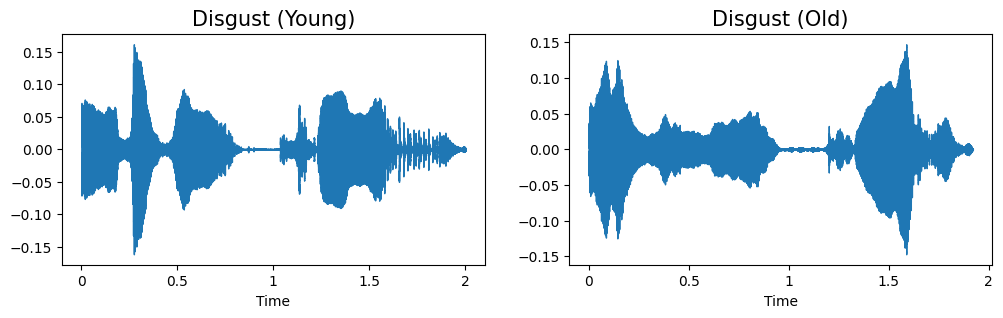

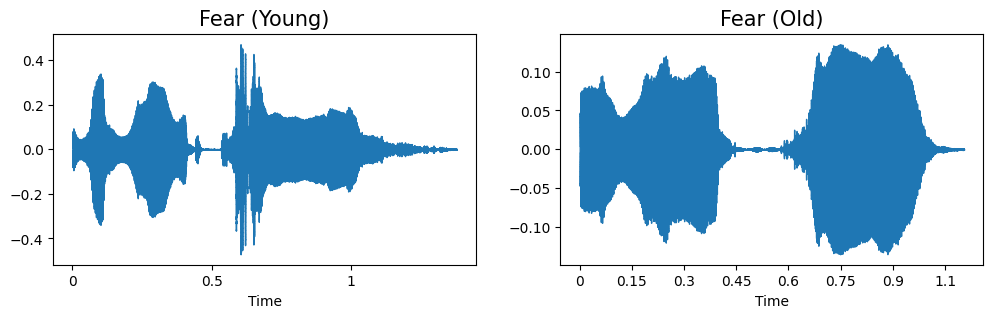

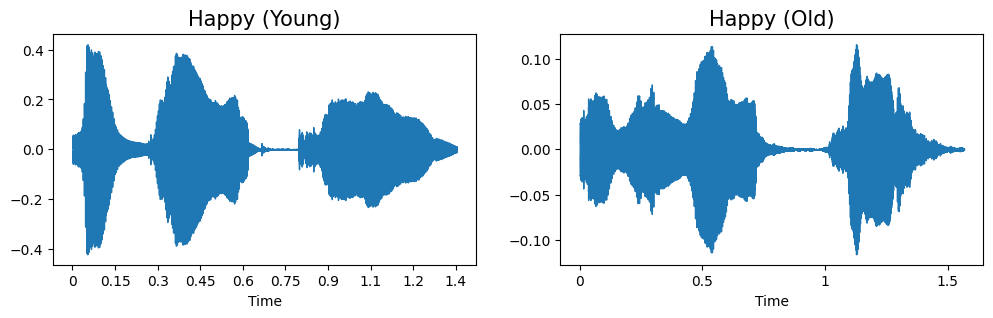

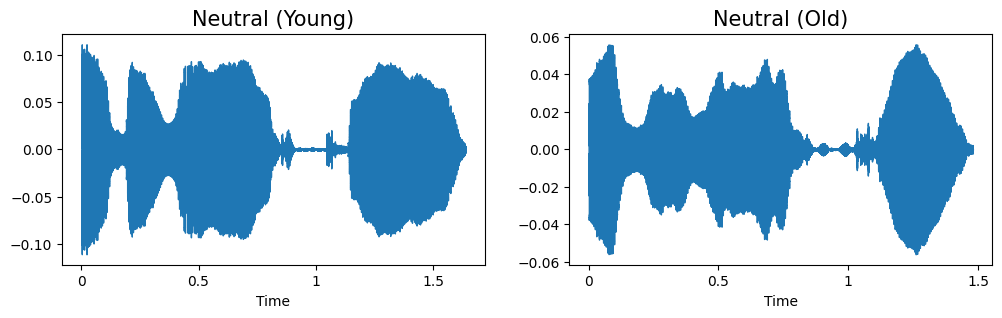

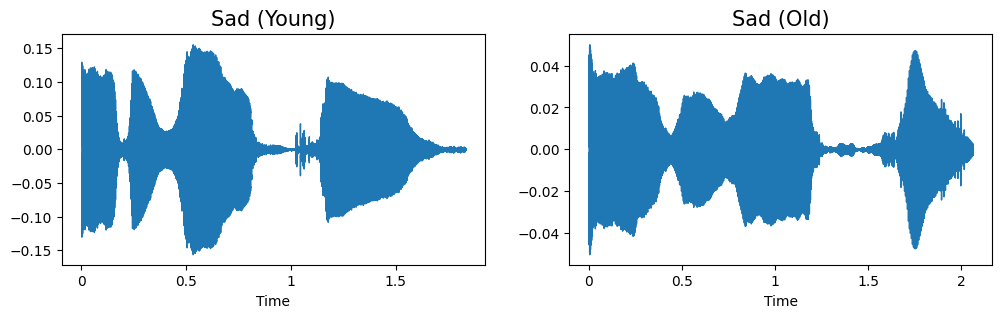

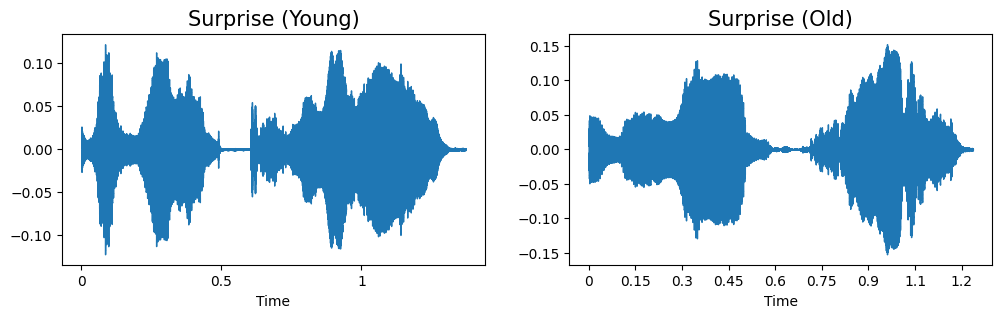

In [8]:
for i in emotions:
    file_paths = df[(df['Emotion'] == i) & (df['Path'].str.contains('cool'))]
    young_path = file_paths[file_paths['Path'].str.contains('YAF')]['Path'].iloc[0]
    old_path = file_paths[file_paths['Path'].str.contains('OAF')]['Path'].iloc[0]

    young_data, sr = librosa.load(young_path, duration=3, offset=0.5)
    old_data, sr = librosa.load(old_path, duration=3, offset=0.5)

    create_waveplot(young_data, old_data, sr, i)

In [9]:
X_mfcc = np.array([extract_mfcc(file) for file in df['Path']])
X_mfcc[0], X_mfcc.shape

(array([-4.62378204e+02,  1.00464325e+02,  1.91995239e+01, -1.64761906e+01,
        -5.92778540e+00,  2.71949911e+00, -8.24235201e-01, -1.91297084e-01,
        -1.38752766e+01, -4.23553276e+00, -1.03414574e+01, -7.82171822e+00,
        -4.98981714e+00, -3.41547608e+00,  4.91798043e-01,  3.12325716e+00,
        -6.83119774e+00,  1.23104010e+01, -5.48023462e-01, -3.48675489e+00,
         1.14385843e+00, -1.89509308e+00, -4.97630119e+00,  2.60477662e+00,
        -2.93660784e+00,  2.71576262e+00,  3.23957980e-01,  8.43251514e+00,
         2.38298726e+00,  8.36340523e+00,  3.46364927e+00,  3.20558715e+00,
         4.02650356e+00,  3.62779999e+00,  3.91358900e+00,  8.99967670e+00,
         7.50483370e+00,  1.18388367e+01,  9.96097660e+00,  1.30425701e+01],
       dtype=float32),
 (2800, 40))

## ***One Hot Encoding***

In [10]:
enc = OneHotEncoder()
y = enc.fit_transform(df[['Emotion']]).toarray()
y[0], y.shape

(array([0., 0., 0., 1., 0., 0., 0.]), (2800, 7))

## ***Split Data into Training and Testing (Equal Distribution)***

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X_mfcc, y, test_size=0.2, random_state=42, stratify=y)

## ***Scale the Data***

In [12]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## ***Reshape input for LSTM***

In [13]:
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

## ***Model Building***

In [14]:
model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(emotions), activation='softmax')
])

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 256)                 │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,799 (1.17 MB)

 Trainable params: 305,799 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

## ***Train the Model***

In [16]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=64)

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.3736 - loss: 1.6453 - val_accuracy: 0.6161 - val_loss: 0.9198
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.7139 - loss: 0.7645 - val_accuracy: 0.8429 - val_loss: 0.4262
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.8141 - loss: 0.4986 - val_accuracy: 0.9250 - val_loss: 0.2144
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - accuracy: 0.9094 - loss: 0.2546 - val_accuracy: 0.9304 - val_loss: 0.1987
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 238ms/step - accuracy: 0.9220 - loss: 0.2243 - val_accuracy: 0.9393 - val_loss: 0.1908
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 0.9248 - loss: 0.2196 - val_accuracy: 0.9393 - val_loss: 0.1983
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 225ms/step - accuracy: 0.9357 - loss: 0.2090 - val_accuracy: 0.8946 - val_loss: 0.3052
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - accuracy: 0.9336 - loss: 0.2080 - val_accuracy

## ***Plot training and validation accuracy and loss***

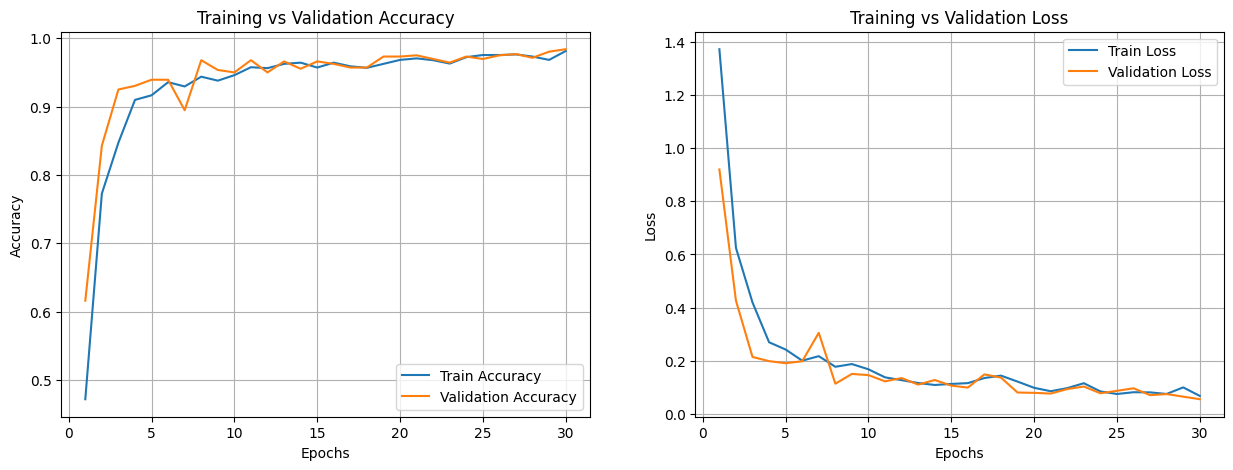

In [17]:
epochs = range(1, 31)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

## ***Evaluate Model Performance***

In [18]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9833 - loss: 0.0661
Test Loss: 0.0555
Test Accuracy: 0.9839


## ***Predict on test data***

In [19]:
y_pred_test = model.predict(x_test)
y_pred = enc.inverse_transform(y_pred_test)
y_true = enc.inverse_transform(y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


## ***Confusion Matrix***

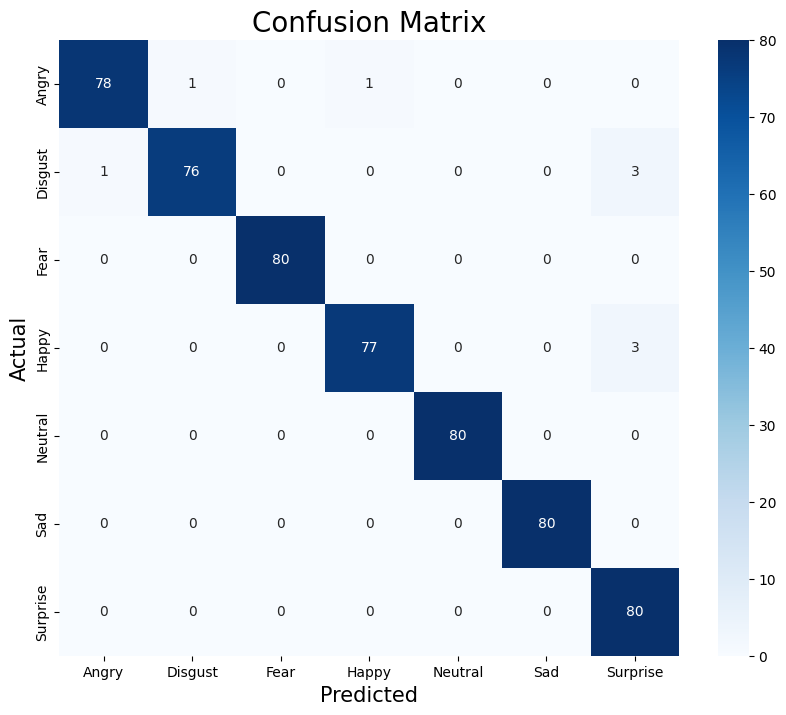

In [20]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel('Predicted', size=15)
plt.ylabel('Actual', size=15)
plt.title('Confusion Matrix', size=20)
plt.show()